This notebook aims at testing supervised learning applied to bot detection on twitter

# Initialization

Imports.\
PySpark is used to manipulate dataframes.

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sqlalchemy import create_engine
from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_curve, auc, classification_report, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier



PySpark session and link to access it.\
Do NOT forget to forward **port 4040** if using SSH.\
http://localhost:4040

In [ ]:
dbname = ''
user = ''
password = ';'
host = ''
port = 

connection_string = f"postgresql+psycopg2://{user}:{password}@/{dbname}"
engine = create_engine(connection_string)

# All datasets

In [114]:
users_cresci2017 = pd.read_sql('SELECT user_id, label, statuses_count, followers_count, friends_count, favourites_count, listed_count FROM cresci_2017_users', engine)
users_cresci2015 = pd.read_sql_query('SELECT user_id, label, statuses_count, followers_count, friends_count, favourites_count, listed_count FROM cresci_2015_users', engine)

### Cresci 2015

In [115]:
users_c15 = pd.read_sql_query('SELECT user_id, label, statuses_count, followers_count, friends_count, favourites_count, listed_count, created_at FROM cresci_2015_users', engine)
tweets_c15 = pd.read_sql_query('SELECT id, user_id, created_at, retweet_count, favorite_count, retweeted_status_id, in_reply_to_status_id FROM cresci_2015_tweets', engine)
tweets_c15 = tweets_c15[tweets_c15.user_id.isin(users_c15.user_id)]

In [118]:
# only select the user_id and retweeted_status_id columns
retweets_count = tweets_c15[['user_id', 'retweeted_status_id']]
retweets_count = retweets_count.groupby('user_id').count()
retweets_count = retweets_count.rename(columns={'retweeted_status_id': 'retweet_count'})

replies_count = tweets_c15[['user_id', 'in_reply_to_status_id']]
replies_count = replies_count.groupby('user_id').count()
replies_count = replies_count.rename(columns={'in_reply_to_status_id': 'reply_count'})

In [119]:
users_c15 = users_c15.merge(retweets_count, on='user_id', how='left')
users_c15 = users_c15.merge(replies_count, on='user_id', how='left')
users_c15['created_at'] = pd.to_datetime(users_c15['created_at'])
users_c15['age'] = (pd.Timestamp.now() - users_c15['created_at']).dt.days
users_c15.drop(columns=['created_at'], inplace=True)
users_c15['favourites_count'] = pd.to_numeric(users_c15['favourites_count'], errors='coerce')
users_c15['statuses_count'] = pd.to_numeric(users_c15['statuses_count'], errors='coerce')
users_c15['fav_tweet_ratio'] = users_c15['favourites_count'] / users_c15['statuses_count']
users_c15['rt_tweet_ratio'] = users_c15['statuses_count'] / users_c15['retweet_count']
users_c15['tweet_frequency'] = users_c15['statuses_count'] / users_c15['age']
users_c15['follow_friend_ratio'] = pd.to_numeric(users_c15['followers_count']) / pd.to_numeric(users_c15['friends_count'])
users_c15 = users_c15[['user_id', 'label', 'age', 'fav_tweet_ratio', 'listed_count', 'follow_friend_ratio', 'rt_tweet_ratio', 'reply_count', 'statuses_count', 'retweet_count', 'tweet_frequency']]



users_c15.head()

,user_id,label,age,fav_tweet_ratio,listed_count,follow_friend_ratio,rt_tweet_ratio,reply_count,statuses_count,retweet_count,tweet_frequency
0,24503,human,6654,0.061521,256,3.448158,1.232604,3521.0,4340,3521.0,0.652239
1,22903,human,6654,0.073171,4,0.680412,1.025000,160.0,164,160.0,0.024647
2,382393,human,6620,0.814019,92,1.387019,1.032819,1036.0,1070,1036.0,0.161631
3,286543,human,6623,0.069356,28,1.738318,2.098021,3285.0,6892,3285.0,1.040616
4,438023,human,6618,0.014211,2,0.389640,1.001736,2880.0,2885,2880.0,0.435932


### Cresci 2017

In [120]:
users_c17 = pd.read_sql_query('SELECT user_id, label, statuses_count, followers_count, friends_count, favourites_count, listed_count, created_at FROM cresci_2017_users', engine)
tweets_c17 = pd.read_sql_query('SELECT id, user_id, created_at, retweet_count, favorite_count, retweeted_status_id, in_reply_to_status_id FROM cresci_2017_tweets', engine)
tweets_c17 = tweets_c17[tweets_c17.user_id.isin(users_c17.user_id)]

In [121]:
# only select the user_id and retweeted_status_id columns
retweets_count = tweets_c17[['user_id', 'retweeted_status_id']]
retweets_count = retweets_count.groupby('user_id').count()
retweets_count = retweets_count.rename(columns={'retweeted_status_id': 'retweet_count'})

replies_count = tweets_c17[['user_id', 'in_reply_to_status_id']]
replies_count = replies_count.groupby('user_id').count()
replies_count = replies_count.rename(columns={'in_reply_to_status_id': 'reply_count'})

In [122]:
users_c17 = users_c17.merge(retweets_count, on='user_id', how='left')
users_c17 = users_c17.merge(replies_count, on='user_id', how='left')
users_c17['created_at'] = pd.to_datetime(users_c17['created_at'])
users_c17['age'] = (pd.Timestamp.now() - users_c17['created_at']).dt.days
users_c17.drop(columns=['created_at'], inplace=True)
users_c17['favourites_count'] = pd.to_numeric(users_c17['favourites_count'], errors='coerce')
users_c17['statuses_count'] = pd.to_numeric(users_c17['statuses_count'], errors='coerce')
users_c17['fav_tweet_ratio'] = users_c17['favourites_count'] / users_c17['statuses_count']
users_c17['rt_tweet_ratio'] = users_c17['statuses_count'] / users_c17['retweet_count']
users_c17['tweet_frequency'] = users_c17['statuses_count'] / users_c17['age']
users_c17['follow_friend_ratio'] = pd.to_numeric(users_c17['followers_count']) / pd.to_numeric(users_c17['friends_count'])
users_c17 = users_c17[['user_id', 'label', 'age', 'fav_tweet_ratio', 'listed_count', 'follow_friend_ratio', 'rt_tweet_ratio', 'reply_count', 'statuses_count', 'retweet_count', 'tweet_frequency']]



users_c17.head()

,user_id,label,age,fav_tweet_ratio,listed_count,follow_friend_ratio,rt_tweet_ratio,reply_count,statuses_count,retweet_count,tweet_frequency
0,2372241176,bot,3999.0,0.0,0,0.217391,0.569892,93.0,53,93.0,0.013253
1,2368684734,bot,4001.0,0.0,0,0.100000,0.647619,105.0,68,105.0,0.016996
2,2353855646,bot,4011.0,0.0,0,0.230769,0.724771,109.0,79,109.0,0.019696
3,2372322542,bot,3999.0,0.0,0,0.025641,0.634409,93.0,59,93.0,0.014754
4,2352506778,bot,4012.0,0.0,0,0.194444,0.623932,117.0,73,117.0,0.018195


### Twibot20

In [123]:
users_tb20 = pd.read_sql_query('SELECT id, tweet_count, followers_count, following_count, listed_count, created_at FROM tb20_users', engine)\
    .rename(columns={'id': 'user_id', 'tweet_count': 'statuses_count', 'following_count': 'friends_count'})
rt_tb20 = pd.read_sql_query('SELECT * FROM tb20_user_retweet', engine)

labels_tb20 = pd.read_sql_query('SELECT * FROM tb20_label', engine)
users_tb20 = users_tb20.merge(labels_tb20, left_on='user_id', right_on='id').drop(columns=['id'])

In [124]:
# Feature engineering
users_tb20['created_at'] = pd.to_datetime(users_tb20['created_at'])
users_tb20['created_at'] = (pd.Timestamp.now() - users_tb20['created_at']).dt.days
users_tb20 = users_tb20.rename(columns={'created_at': 'age'})
users_tb20['follow_friend_ratio'] = users_tb20['followers_count'] / users_tb20['friends_count']
users_tb20 = users_tb20.merge(rt_tb20, left_on='user_id', right_on='user_id', how='left').fillna(0)
users_tb20['rt_tweet_ratio'] = users_tb20['retweet_count'] / users_tb20['statuses_count']
users_tb20['tweet_frequency'] = users_tb20['statuses_count'] / users_tb20['age']
users_tb20 = users_tb20.fillna(0)
users_tb20['favourite_count'] = 0
users_tb20['fav_tweet_ratio'] = 0
users_tb20['reply_count'] = 0
users_tb20 = users_tb20[['user_id', 'label', 'age', 'fav_tweet_ratio', 'listed_count', 'follow_friend_ratio', 'rt_tweet_ratio', 'reply_count', 'statuses_count', 'retweet_count', 'tweet_frequency']]

users_tb20.head()

,user_id,label,age,fav_tweet_ratio,listed_count,follow_friend_ratio,rt_tweet_ratio,reply_count,statuses_count,retweet_count,tweet_frequency
0,u17461978,human,5931,0,45568.0,22181.497110,0.003368,0,9798.0,33.0,1.651998
1,u1297437077403885568,bot,1636,0,0.0,0.000000,0.000000,0,0.0,0.0,0.000000
2,u17685258,human,5922,0,3201.0,1605.976842,0.023559,0,5518.0,130.0,0.931780
3,u15750898,human,6035,0,1744.0,68.233076,0.000394,0,192876.0,76.0,31.959569
4,u1659167666,bot,4206,0,44.0,20.593509,0.446602,0,103.0,46.0,0.024489


### Twibot22

In [125]:
users_tb22 = pd.read_sql_query('SELECT id, tweet_count, followers_count, following_count, listed_count, created_at FROM tb22_user', engine)\
    .rename(columns={'id': 'user_id', 'tweet_count': 'statuses_count', 'following_count': 'friends_count'})
labels_tb22 = pd.read_sql_query('SELECT * FROM tb22_label', engine)
users_tb22 = users_tb22.merge(labels_tb22, left_on='user_id', right_on='id').drop(columns=['id'])

tweets_tb22 = pd.read_sql_query('SELECT id, author_id, retweet_count, like_count FROM tb22_tweet', engine)
tweets_tb22['author_id'] = 'u' + tweets_tb22['author_id'].astype(str)
retweets_tb22 = pd.read_sql_query('SELECT * FROM tb22_retweet', engine)
replies_tb22 = pd.read_sql_query('SELECT * FROM tb22_reply', engine)

In [126]:
# Feature engineering
users_tb22 = users_tb22.merge(replies_tb22.groupby('source_id').sum('count').rename(columns={'count': 'reply_count'}), left_on='user_id', right_on='source_id', how='left')
users_tb22 = users_tb22.merge(retweets_tb22.groupby('source_id').sum('count').rename(columns={'count': 'retweet_count'}), left_on='user_id', right_on='source_id', how='left')
users_tb22['created_at'] = pd.to_datetime(users_tb22['created_at'])
users_tb22['created_at'] = (pd.Timestamp.now() - users_tb22['created_at']).dt.days
users_tb22.rename(columns={'created_at': 'age'}, inplace=True)
users_tb22['follow_friend_ratio'] = users_tb22['followers_count'] / users_tb22['friends_count']
users_tb22 = users_tb22.merge(tweets_tb22[['author_id', 'like_count']].groupby('author_id').sum('like_count').rename(columns={'like_count': 'fav_received'}), left_on='user_id', right_on='author_id', how='left')
users_tb22['fav_tweet_ratio'] = users_tb22['fav_received'] / users_tb22['statuses_count']
users_tb22['rt_tweet_ratio'] = users_tb22['retweet_count'] / users_tb22['statuses_count']
users_tb22['tweet_frequency'] = users_tb22['statuses_count'] / users_tb22['age']
users_tb22 = users_tb22[['user_id', 'label', 'age', 'fav_tweet_ratio', 'listed_count', 'follow_friend_ratio', 'rt_tweet_ratio', 'reply_count', 'statuses_count', 'retweet_count', 'tweet_frequency']]
users_tb22 = users_tb22.fillna(0)

users_tb22.head(3)

,user_id,label,age,fav_tweet_ratio,listed_count,follow_friend_ratio,rt_tweet_ratio,reply_count,statuses_count,retweet_count,tweet_frequency
0,u1217628182611927040,human,1856,5.975468,69,34.027907,0.074564,532.0,3098,231.0,1.669181
1,u2664730894,human,3879,0.131103,0,0.112844,0.182117,290.0,1823,332.0,0.469966
2,u1266703520205549568,human,1720,0.378788,0,0.048387,0.045455,28.0,66,3.0,0.038372


### Aditional info

In [ ]:
df_list = [users_c15, users_c17, users_tb20, users_tb22]
df_names = ['cresci2015', 'cresci2017', 'tb20', 'tb22']


In [ ]:
# for each dataset, turn label into label_num
for i, df in enumerate(df_list):
    df['label_num'] = df['label'].map({'human': 0, 'bot': 1})
    df.drop(columns=['label'], inplace=True)

In [144]:
# clear all nans
for i, df in enumerate(df_list):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

# Model

In this cell, all the functions are defined

In [110]:
# Object used to store the results of the prediction
class Report:
    def __init__(self, accuracy, precision, recall, specificity, f1, mcc, roc_auc):
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.specificity = specificity
        self.f1 = f1
        self.mcc = mcc
        self.roc_auc = roc_auc

    def __str__(self):
        return f"Accuracy: {self.accuracy:.4f}\nPrecision: {self.precision:.4f}\nRecall: {self.recall:.4f}\nSpecificity: {self.specificity:.4f}\nF1: {self.f1:.4f}\nMCC: {self.mcc:.4f}\nAUC: {self.roc_auc:.4f}"

    def __repr__(self):
        return f"Accuracy: {self.accuracy:.4f}\nPrecision: {self.precision:.4f}\nRecall: {self.recall:.4f}\nSpecificity: {self.specificity:.4f}\nF1: {self.f1:.4f}\nMCC: {self.mcc:.4f}\nAUC: {self.roc_auc:.4f}"

# Function to split the dataset into training and testing sets. If notest is set to True, the testing set is empty (for cross-validation)
def split(df, prop_bot, balancing=True, notest=False, testprop=0.2):
    df_bot = df[df['label_num'] == 1]
    df_human = df[df['label_num'] == 0]

    if balancing:
        nb_bots = len(df_bot)
        nb_humans = len(df_human)

        sample_nb_humans = min(nb_bots / prop_bot, nb_humans)
        sample_nb_bots = sample_nb_humans * prop_bot
        
        if sample_nb_bots < 5:
            sample_nb_bots = 5
        if sample_nb_humans < 5:
            sample_nb_humans = 5
        
        df_bot = df_bot.sample(int(sample_nb_bots))
        df_human = df_human.sample(int(sample_nb_humans))

    df = pd.concat([df_bot, df_human])
    X = df.drop(columns=['label_num', 'user_id'])
    y = df['label_num']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testprop, stratify=y)

    if notest:
        X_train = X
        y_train = y
        X_test = []
        y_test = []

    return X_train, X_test, y_train, y_test  

# Function to split the dataset into training and testing sets
def split_test(df, prop_bot):
    df_bot = df[df['label_num'] == 1]
    df_human = df[df['label_num'] == 0]

    nb_bots = len(df_human) * prop_bot
    df_bot = df_bot.sample(int(nb_bots))

# Function to train the model, using grid search if specified
def train(X_train, y_train, using_grid_search=True):
    if not using_grid_search:
        rf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True)
        rf.fit(X_train, y_train)
        # scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='matthews_corrcoef')
        return rf
    
    rf = RandomForestClassifier()
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 50, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 4],
        'bootstrap': [True]
    }
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0) # CROSS VALIDATION 5 FOLDS 
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

# Function to train the model using cross-validation with 5 folds
def train_cv(X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True)
    
    reports = []

    for train_index, test_index in cv.split(X, y):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        clf = clone(model)
        clf.fit(X_train_cv, y_train_cv)

        y_pred = clf.predict(X_test_cv)
        y_prob = clf.predict_proba(X_test_cv)[:, 1]

        acc = accuracy_score(y_test_cv, y_pred)
        prec = precision_score(y_test_cv, y_pred)
        rec = recall_score(y_test_cv, y_pred)
        spec = recall_score(y_test_cv, y_pred, pos_label=0)
        f1 = f1_score(y_test_cv, y_pred)
        mcc = matthews_corrcoef(y_test_cv, y_pred)
        roc_auc = roc_auc_score(y_test_cv, y_prob)
        
        # create a report object
        report = Report(acc, prec, rec, spec, f1, mcc, roc_auc)
        reports.append(report)

    return reports

# Function to evaluate the model using various metrics
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1] 

    cm = confusion_matrix(y_test, y_pred)
    tp, fp, fn, tn = cm.ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_scores)

    return Report(accuracy, precision, recall, specificity, f1, mcc, roc_auc)

# Function running a series of tests and returning the results
def run_test(df, prop_bot, repetitions, using_fav_count=True, using_grid_search=False, balancing=True):
    reports = []
    for _ in range(repetitions):
        X_train, X_test, y_train, y_test = split(df, prop_bot, using_fav_count, balancing)
        model = train(X_train, y_train, using_grid_search)
        report = evaluate(model, X_test, y_test)
        reports.append(report)
    return reports

# Function running a series of tests using cross-validation and returning the results
def run_test_cv(df, prop_bot, balancing=True):
    X_train, X_test, y_train, y_test = split(df, prop_bot, balancing, notest=True)
    reports = train_cv(X_train, y_train)
    return reports

# Function running a series of tests on a training set and a different testing set and returning the results
def run_on_other(df_train, df_test, prop_bot, repetitions, using_fav_count=True, using_grid_search=False, balancing=True):
    reports = []
    for _ in range(repetitions):
        X_train, _, y_train, _ = split(df_train, prop_bot, using_fav_count, balancing, notest=True)
        X_test, _, y_test, _ = split(df_test, prop_bot, using_fav_count, balancing, notest=True)
        model = train(X_train, y_train, using_grid_search)
        report = evaluate(model, X_test, y_test)
        reports.append(report)
    return reports

# Function to print the average and standard deviation of each metric
def print_avg_std(reports):
    accuracy = np.mean([r.accuracy for r in reports])
    precision = np.mean([r.precision for r in reports])
    recall = np.mean([r.recall for r in reports])
    specificity = np.mean([r.specificity for r in reports])
    f1 = np.mean([r.f1 for r in reports])
    mcc = np.mean([r.mcc for r in reports])
    roc_auc = np.mean([r.roc_auc for r in reports])

    accuracy_std = np.std([r.accuracy for r in reports])
    precision_std = np.std([r.precision for r in reports])
    recall_std = np.std([r.recall for r in reports])
    specificity_std = np.std([r.specificity for r in reports])
    f1_std = np.std([r.f1 for r in reports])
    mcc_std = np.std([r.mcc for r in reports])
    roc_auc_std = np.std([r.roc_auc for r in reports])

    print("Accuracy:", accuracy, "+-", accuracy_std)
    print("Precision:", precision, "+-", precision_std)
    print("Recall:", recall, "+-", recall_std)
    print("Specificity:", specificity, "+-", specificity_std)
    print("F1:", f1, "+-", f1_std)
    print("MCC:", mcc, "+-", mcc_std)
    print("ROC AUC:", roc_auc, "+-", roc_auc_std)


# TRAINING and TESTING on the same dataset

### Framework

Function calculating all the metrics over 3 series, average and std. 

Places the results in a CSV under the results/abreu/ directory on top of printing them

In [ ]:
def run_tests(prop_bot, filename, balancing=True):
    os.makedirs('./results/gilani', exist_ok=True)

    results = []

    for df, name in tqdm(zip(df_list, df_names), total=len(df_list)):
        reports = run_test_cv(df, prop_bot, balancing=balancing)
        accuracy = np.mean([r.accuracy for r in reports])
        precision = np.mean([r.precision for r in reports])
        recall = np.mean([r.recall for r in reports])
        specificity = np.mean([r.specificity for r in reports])
        f1 = np.mean([r.f1 for r in reports])
        mcc = np.mean([r.mcc for r in reports])
        roc_auc = np.mean([r.roc_auc for r in reports])

        accuracy_std = np.std([r.accuracy for r in reports])
        precision_std = np.std([r.precision for r in reports])
        recall_std = np.std([r.recall for r in reports])
        specificity_std = np.std([r.specificity for r in reports])
        f1_std = np.std([r.f1 for r in reports])
        mcc_std = np.std([r.mcc for r in reports])
        roc_auc_std = np.std([r.roc_auc for r in reports])

        results.append([name, accuracy, accuracy_std, precision, precision_std, recall, recall_std, specificity, specificity_std, f1, f1_std, mcc, mcc_std, roc_auc, roc_auc_std])

    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results, columns=['dataset', 'accuracy', 'accuracy_std', 'precision', 'precision_std', 'recall', 'recall_std', 'specificity', 'specificity_std', 'f1', 'f1_std', 'mcc', 'mcc_std', 'roc_auc', 'roc_auc_std'])
    results_df.to_csv(f'./results/gilani/{filename}.csv', index=False)
    return results_df
    

### Sample statistics

Since each dataset is sampled so as to obtain the required bot/human ratio, this cell shows the size of each sample, for each dataset and bot/human prop.

In [16]:
def show_dataset_stats():
    prop_bots = [1, 1/4, 1/9, 1/19]
    
    for prop_bot in prop_bots:
        results = []
        for df, name in zip(df_list, df_names):
            df_bot = df[df['label'] == 'bot']
            df_human = df[df['label'] == 'human']

            nb_bots = len(df_bot)
            nb_humans = len(df_human)

            sample_nb_humans = min(nb_bots / prop_bot, nb_humans)
            sample_nb_bots = sample_nb_humans * prop_bot

            results.append([name, nb_bots, nb_humans, sample_nb_bots, sample_nb_humans])

        print(f"############### prop_bot: {prop_bot}")
        results_df = pd.DataFrame(results, columns=['dataset', 'nb_bots', 'nb_humans', 'sampled_nb_bots', 'sampled_nb_humans'])
        print(results_df)

show_dataset_stats()

############### prop_bot: 1
             dataset  nb_bots  nb_humans  sampled_nb_bots  sampled_nb_humans
0         cresci2017     8263       3474           3474.0             3474.0
1         cresci2015     3349       1952           1952.0             1952.0
2             gilani     1090       1413           1090.0             1090.0
3       crescirtbust      353        340            340.0              340.0
4            midterm    42446       8092           8092.0             8092.0
5  botometerfeedback      139        380            139.0              139.0
6               tb20     6589       5237           5237.0             5237.0
7               tb22   139943     860057         139943.0           139943.0
############### prop_bot: 0.25
             dataset  nb_bots  nb_humans  sampled_nb_bots  sampled_nb_humans
0         cresci2017     8263       3474           868.50             3474.0
1         cresci2015     3349       1952           488.00             1952.0
2             gil

### 50/50

In [155]:
balanced = run_tests(1, '50', True)
print(balanced)

100%|██████████| 4/4 [04:41<00:00, 70.35s/it] 

      dataset  accuracy  accuracy_std  precision  precision_std    recall  \
0  cresci2017  0.984765      0.006943   0.987040       0.006793  0.982467   
1  cresci2015  0.977913      0.004412   0.981380       0.004124  0.974314   
2        tb20  0.722491      0.007019   0.697677       0.009371  0.785701   
3        tb22  0.734595      0.001940   0.710299       0.002265  0.792380   

   recall_std  specificity  specificity_std        f1    f1_std       mcc  \
0    0.010658     0.987067         0.006800  0.984717  0.006974  0.969602   
1    0.005876     0.981507         0.004123  0.977828  0.004448  0.955863   
2    0.006029     0.659281         0.016408  0.739017  0.004784  0.448650   
3    0.002452     0.676810         0.003680  0.749094  0.001687  0.472360   

    mcc_std   roc_auc  roc_auc_std  
0  0.013870  0.997126     0.002252  
1  0.008818  0.994307     0.000905  
2  0.013209  0.794848     0.007321  
3  0.003808  0.800243     0.001894  


### 20/80

In [ ]:
unbalanced20 = run_tests(1/4, '20', True)
print(unbalanced20)

100%|██████████| 4/4 [13:26<00:00, 201.67s/it]

      dataset  accuracy  accuracy_std  precision  precision_std    recall  \
0  cresci2017  0.985959      0.005908   0.963088       0.011731  0.966667   
1  cresci2015  0.978630      0.008067   0.942175       0.033260  0.952725   
2        tb20  0.810360      0.004269   0.552444       0.025134  0.281443   
3        tb22  0.808008      0.000453   0.549787       0.002427  0.221010   

   recall_std  specificity  specificity_std        f1    f1_std       mcc  \
0    0.021596     0.990771         0.002908  0.964796  0.014957  0.956090   
1    0.021058     0.985111         0.008648  0.947020  0.019657  0.933974   
2    0.023806     0.942572         0.009041  0.371899  0.019167  0.296155   
3    0.003365     0.954757         0.000473  0.315270  0.003717  0.258562   

    mcc_std   roc_auc  roc_auc_std  
0  0.018686  0.996748     0.004314  
1  0.024842  0.993331     0.004700  
2  0.015345  0.791912     0.007119  
3  0.003100  0.800470     0.000953  


: 

### 10/90

In [151]:
unbalanced10 = run_tests(1/9, '10', True)
print(unbalanced10)

100%|██████████| 4/4 [20:14<00:00, 303.73s/it]

      dataset  accuracy  accuracy_std  precision  precision_std    recall  \
0  cresci2017  0.986691      0.005537   0.934836       0.039834  0.933333   
1  cresci2015  0.987519      0.004758   0.934475       0.039702  0.944292   
2        tb20  0.898179      0.002167   0.422672       0.100299  0.064183   
3        tb22  0.899432      0.000131   0.440403       0.010705  0.020799   

   recall_std  specificity  specificity_std        f1    f1_std       mcc  \
0    0.033333     0.992605         0.004721  0.933457  0.027760  0.926454   
1    0.043213     0.992293         0.005394  0.938023  0.022798  0.931934   
2    0.023502     0.990749         0.001444  0.110957  0.038515  0.133564   
3    0.001198     0.997058         0.000248  0.039713  0.002166  0.078102   

    mcc_std   roc_auc  roc_auc_std  
0  0.030768  0.993137     0.009100  
1  0.024920  0.993208     0.005039  
2  0.047874  0.763074     0.009895  
3  0.002223  0.799123     0.001198  


### 5/95

In [152]:
unbalanced5 = run_tests(1/19, '5', True)
print(unbalanced5)

100%|██████████| 4/4 [19:03<00:00, 285.88s/it]

      dataset  accuracy  accuracy_std  precision  precision_std    recall  \
0  cresci2017  0.992982      0.006564   0.977778       0.044444  0.875758   
1  cresci2015  0.986827      0.011501   0.855056       0.133755  0.911905   
2        tb20  0.948554      0.000881   0.123810       0.152381  0.010909   
3        tb22  0.949858      0.000031   0.276179       0.051242  0.001783   

   recall_std  specificity  specificity_std        f1    f1_std       mcc  \
0    0.107736     0.999078         0.001843  0.921818  0.074435  0.920869   
1    0.063210     0.990753         0.009281  0.879491  0.096223  0.874784   
2    0.014545     0.997880         0.001416  0.019800  0.026043  0.026145   
3    0.000417     0.999756         0.000025  0.003543  0.000827  0.018637   

    mcc_std   roc_auc  roc_auc_std  
0  0.075979  0.988101     0.020624  
1  0.100206  0.995636     0.003111  
2  0.042097  0.769619     0.028298  
3  0.004525  0.791220     0.002741  


### 1/99

In [153]:
unbalanced1 = run_tests(1/99, '1', True)
print(unbalanced1)

 25%|██▌       | 1/4 [00:00<00:02,  1.37it/s]/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 50%|█████     | 2/4 [00:01<00:01,  1.20it/s]/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

      dataset  accuracy  accuracy_std  precision  precision_std    recall  \
0  cresci2017  0.998169      0.002242       1.00       0.000000  0.800000   
1  cresci2015  0.993389      0.002588       0.62       0.370945  0.500000   
2        tb20  0.990078      0.000465       0.00       0.000000  0.000000   
3        tb22  0.989989      0.000005       0.04       0.080000  0.000116   

   recall_std  specificity  specificity_std        f1    f1_std       mcc  \
0    0.244949     1.000000         0.000000  0.866667  0.163299  0.882192   
1    0.273861     0.997946         0.002516  0.538095  0.291839  0.546432   
2    0.000000     1.000000         0.000000  0.000000  0.000000  0.000000   
3    0.000232     0.999987         0.000007  0.000232  0.000463  0.001809   

    mcc_std   roc_auc  roc_auc_std  
0  0.144285  0.999074     0.001852  
1  0.297480  0.998075     0.001282  
2  0.000000  0.705738     0.071060  
3  0.004241  0.776030     0.003664  


### No Balancing

In [154]:
results = run_tests(1, 'nobal', False)
print(results)

100%|██████████| 4/4 [20:41<00:00, 310.44s/it]

      dataset  accuracy  accuracy_std  precision  precision_std    recall  \
0  cresci2017  0.987957      0.003118   0.995322       0.002565  0.990931   
1  cresci2015  0.976474      0.006217   0.982428       0.004803  0.979663   
2        tb20  0.743325      0.007640   0.733778       0.006921  0.846798   
3        tb22  0.862250      0.000262   0.506834       0.006341  0.076842   

   recall_std  specificity  specificity_std        f1    f1_std       mcc  \
0    0.002493     0.966748         0.018362  0.993119  0.001782  0.945172   
1    0.005326     0.971240         0.007843  0.981043  0.005015  0.950055   
2    0.011037     0.613029         0.014251  0.786202  0.006608  0.476888   
3    0.001648     0.988025         0.000302  0.133445  0.002579  0.156307   

    mcc_std   roc_auc  roc_auc_std  
0  0.014255  0.997341     0.001539  
1  0.013190  0.994671     0.003465  
2  0.015908  0.799940     0.009554  
3  0.002855  0.801084     0.001260  


# Generalization

For each dataset, a model is trained on it, and tested on the rest

### Layout

In [ ]:
def train_test_on_all(bot_prop, filename, legend, balancing=True):

    # TRAIN ON ALL, TEST ON ALL

    df_results = pd.DataFrame(index=df_names, columns=df_names)

    for train_df, train_name in zip(df_list, df_names):
        X_train, _, y_train, _ = split(train_df, bot_prop, balancing=True, notest=True)
        model = train(X_train, y_train, False)

        for test_df, test_name in zip(df_list, df_names):
            X_test, _, y_test, _ = split(test_df, bot_prop, balancing=True, notest=True)
            report = evaluate(model, X_test, y_test)
            df_results.loc[train_name, test_name] = report.mcc

    # to normalize MCC, we add 1 first to avoid negative values
    #df_results_normalized = df_results.add(1)
    #df_results_normalized = df_results.div(df_results.max(axis=1), axis=0)
    #df_results_normalized = df_results_normalized.apply(pd.to_numeric)
    df_results_normalized = df_results.apply(pd.to_numeric)


    # PLOT

    plt.figure(figsize=(10, 8))
    sns.heatmap(df_results_normalized, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'MCC'}, annot_kws={'size': 18}, vmin=-1, vmax=1)
    plt.title(legend)
    plt.xlabel("Test Datasets")
    plt.ylabel("Train Datasets")
    plt.tight_layout()
    plt.show()


    # SAVE TO CSV

    df_results.to_csv(f'./results/gilani/{filename}.csv', index=True)

### Balanced (50/50)

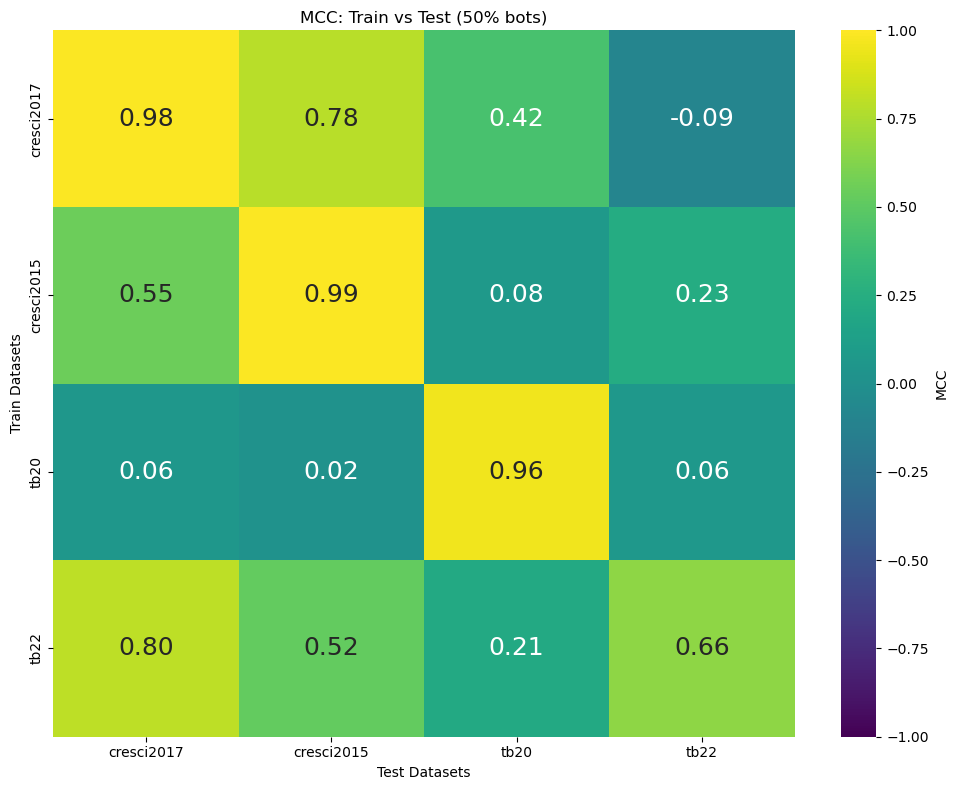

In [145]:
train_test_on_all(1, 'train_test_50', "MCC: Train vs Test (50% bots)", True)

### 20/80

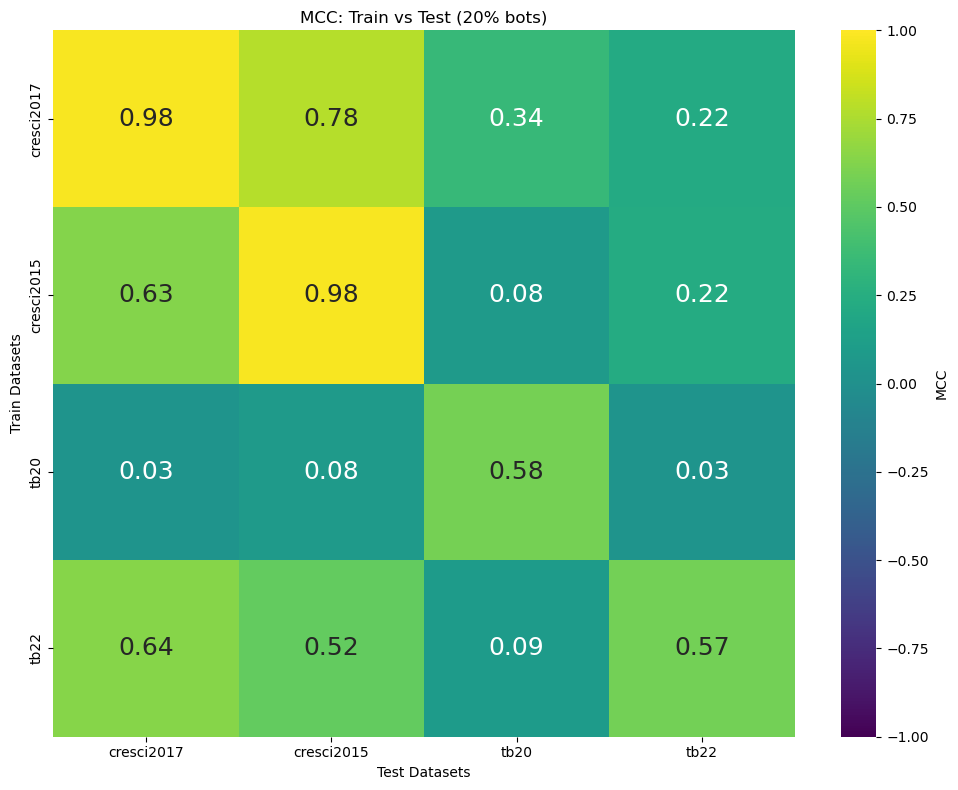

In [146]:
train_test_on_all(1/4, 'train_test_20', "MCC: Train vs Test (20% bots)", True)

### 10/90

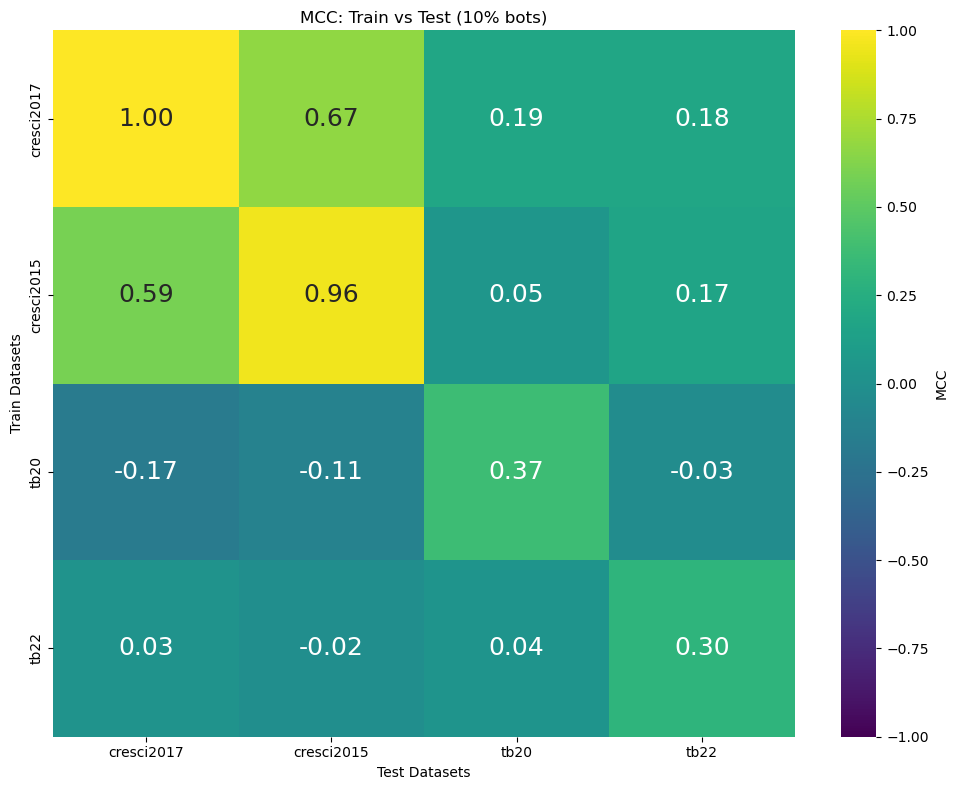

In [147]:
train_test_on_all(1/9, 'train_test_10', "MCC: Train vs Test (10% bots)", True)

### 5/95

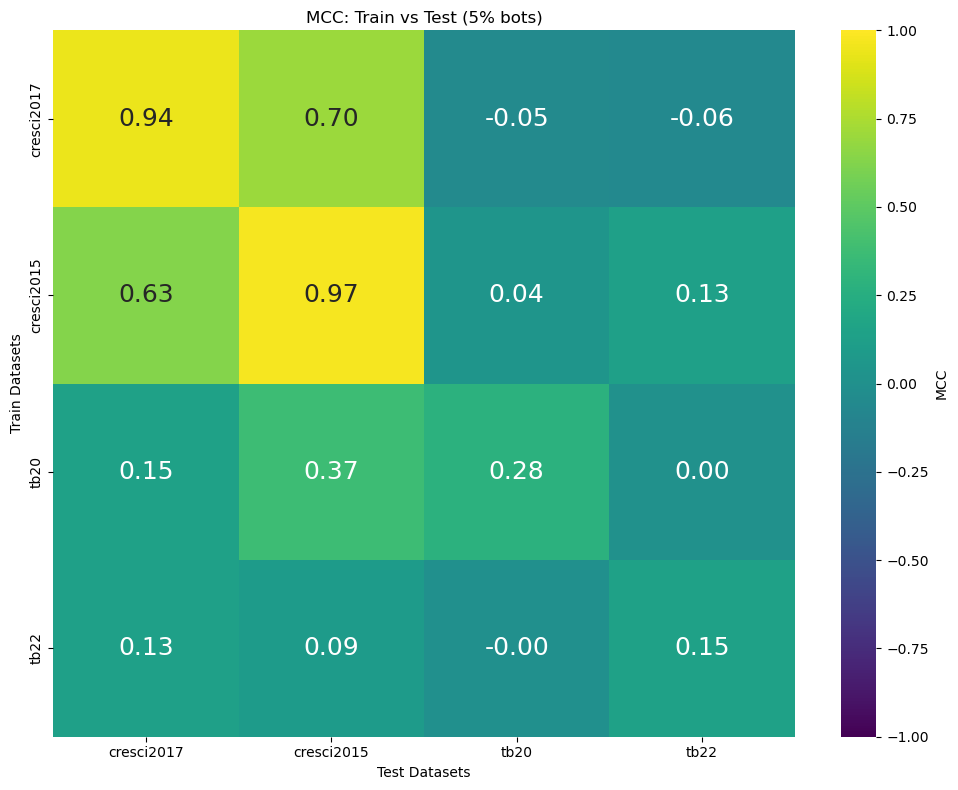

In [148]:
train_test_on_all(1/19, 'train_test_5', "MCC: Train vs Test (5% bots)", True)

### 1/99

/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344

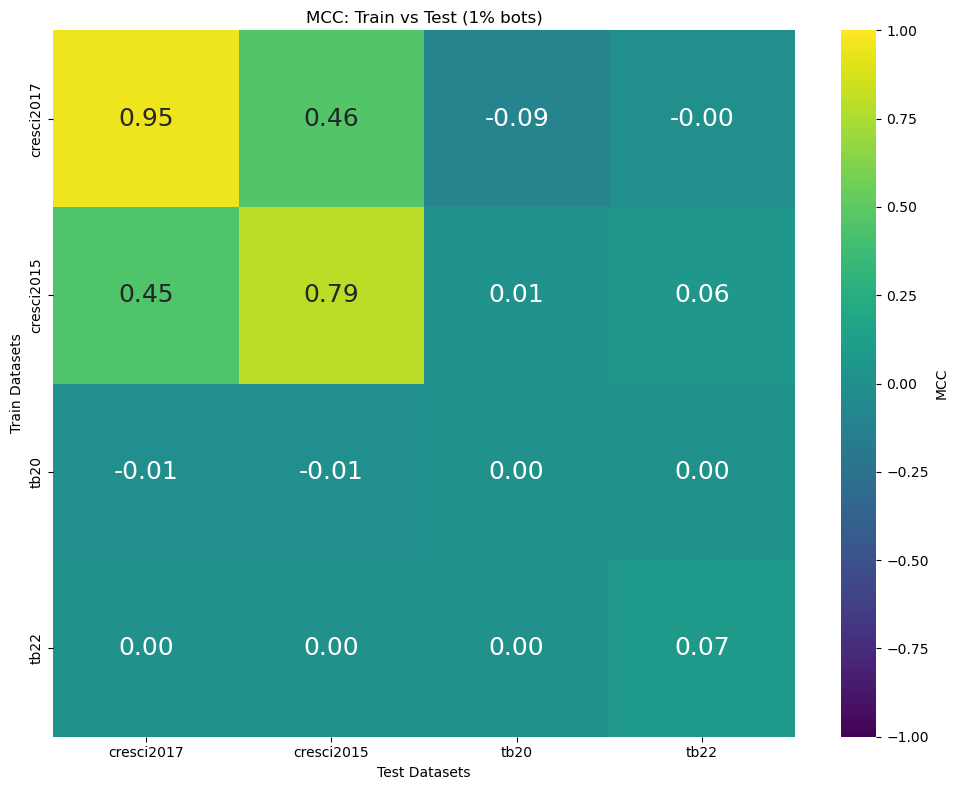

In [149]:
train_test_on_all(1/99, 'train_test_1', "MCC: Train vs Test (1% bots)", False)

### No balancing

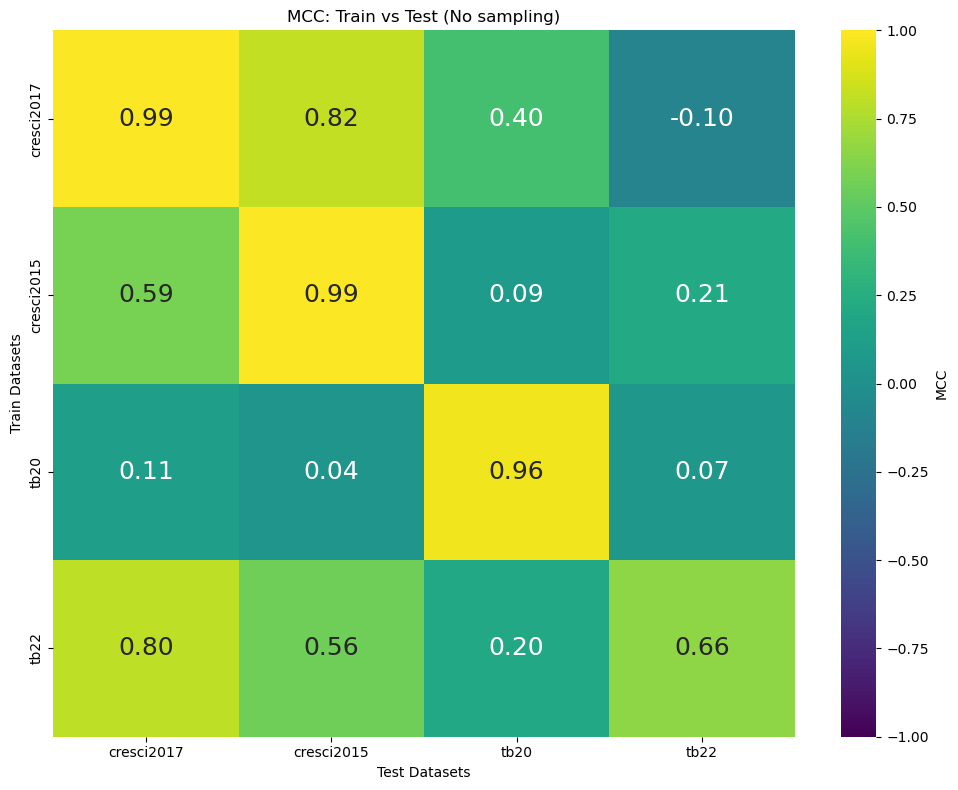

In [150]:
train_test_on_all(1, 'train_test_on_all_nobalancing', "MCC: Train vs Test (No sampling)", False)